# **Dataset info**
*   FER-2013 Dataset
*   Size: ~28,709 images
*   Classes: 7 different expression






# **Import all the required libraries**

In [15]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix
import kagglehub

# **Find train/test dataset folders**

In [16]:
path = kagglehub.dataset_download("msambare/fer2013")
print("Base dataset path:", path)

train_path, test_path = None, None
for root, dirs, files in os.walk(path):
    if "train" in dirs:
        train_path = os.path.join(root, "train")
    if "test" in dirs:
        test_path = os.path.join(root, "test")

if not train_path or not test_path:
    raise FileNotFoundError("Train/Test folders not found!")

print("✅ Train folder:", train_path)
print("✅ Test folder:", test_path)

classes = os.listdir(train_path)
print("Emotion Classes:", classes)

📂 Base dataset path: /kaggle/input/fer2013
✅ Train folder: /kaggle/input/fer2013/train
✅ Test folder: /kaggle/input/fer2013/test
Emotion Classes: ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']


# **Prepare images with augmentation.**


*  **train_datagen** → applies rescaling + rotation, shift, shear, zoom, flip.

*  **val_datagen** → only rescales (no augmentation).

*  **flow_from_directory** → loads dataset into batches for training & validation.



In [22]:
base_path = "/kaggle/input/fer2013"
train_dir = os.path.join(base_path, "train")
test_dir = os.path.join(base_path, "test")

img_size = (96, 96)
batch_size = 64

train_dir = "/kaggle/input/fer2013"
val_dir   = "/kaggle/input/fer2013"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 35887 images belonging to 2 classes.
Found 35887 images belonging to 2 classes.


# **Visualize sample training images.**
*  **class_labels** → gets emotion class names.

*  **next(train_gen)** → fetches one batch of images & labels.


Class Labels: ['test', 'train']


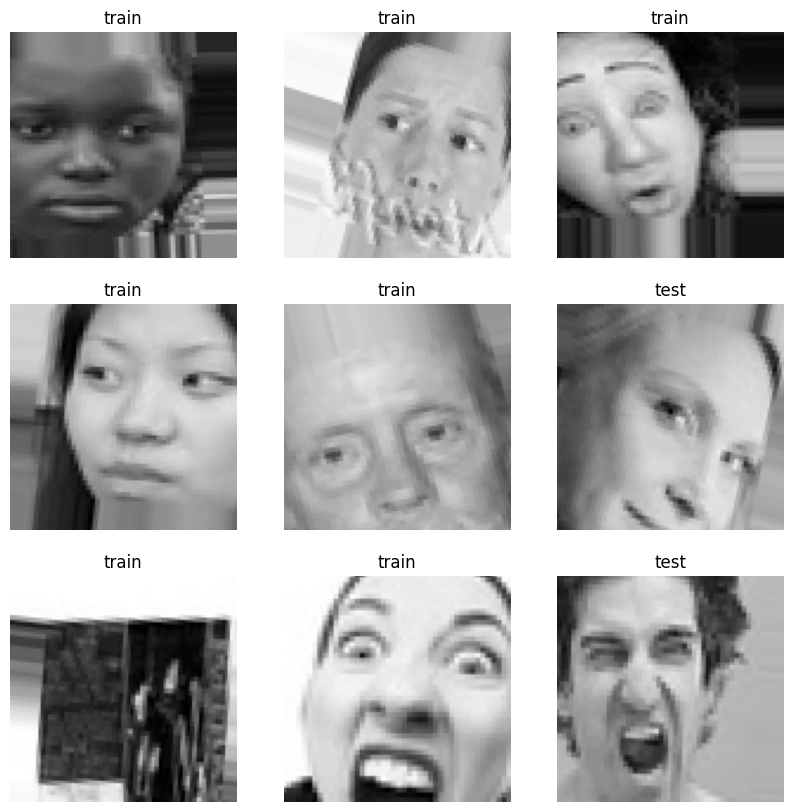

In [23]:
class_labels = list(train_gen.class_indices.keys())
print("Class Labels:", class_labels)


x_batch, y_batch = next(train_gen)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch[i])
    plt.title(class_labels[np.argmax(y_batch[i])])
    plt.axis("off")
plt.show()

# **Multi-Class CNN Classifier**

In [24]:
model = Sequential()

# Conv Block 1
model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_size[0], img_size[1], 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 2
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 3
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 4 (added for better feature extraction)
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Fully Connected
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(train_gen.num_classes, activation='softmax'))

# Compile
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,110,466 (19.49 MB)

 Trainable params: 5,109,506 (19.49 MB)

 Non-trainable params: 960 (3.75 KB)

# **Training with Validation Data**

In [26]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)

Epoch 1/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 183s 326ms/step - accuracy: 0.7996 - loss: 0.5084 - val_accuracy: 0.7821 - val_loss: 0.5476
Epoch 2/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 219s 391ms/step - accuracy: 0.8006 - loss: 0.5077 - val_accuracy: 0.7572 - val_loss: 0.5740
Epoch 3/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 182s 325ms/step - accuracy: 0.8005 - loss: 0.5065 - val_accuracy: 0.7990 - val_loss: 0.5237
Epoch 4/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 187s 334ms/step - accuracy: 0.7976 - loss: 0.5117 - val_accuracy: 0.7983 - val_loss: 0.5272
Epoch 5/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 184s 328ms/step - accuracy: 0.8012 - loss: 0.5066 - val_accuracy: 0.7958 - val_loss: 0.5353
Epoch 6/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 219s 391ms/step - accuracy: 0.8003 - loss: 0.5086 - val_accuracy: 0.7964 - val_loss: 0.5271
Epoch 7/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 225s 326ms/step - accuracy: 0.7997 - loss: 0.5083 - val_accuracy: 0.8000 - val_loss: 0.5279
Epoch 8/15
561/561 ━━━━━━━━━━━━━━━━━━━━ 185s 330ms/step - accuracy: 0.8009 -

# **Training vs Validation Accuracy**

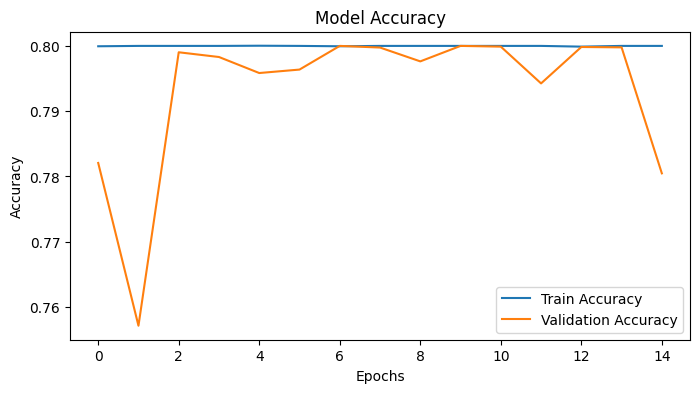

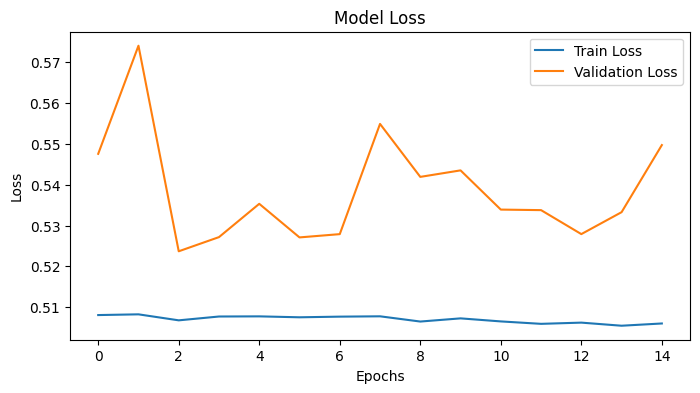

In [28]:
# Accuracy Plot
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss Plot
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# **Classification Results Overview**

561/561 ━━━━━━━━━━━━━━━━━━━━ 46s 81ms/step


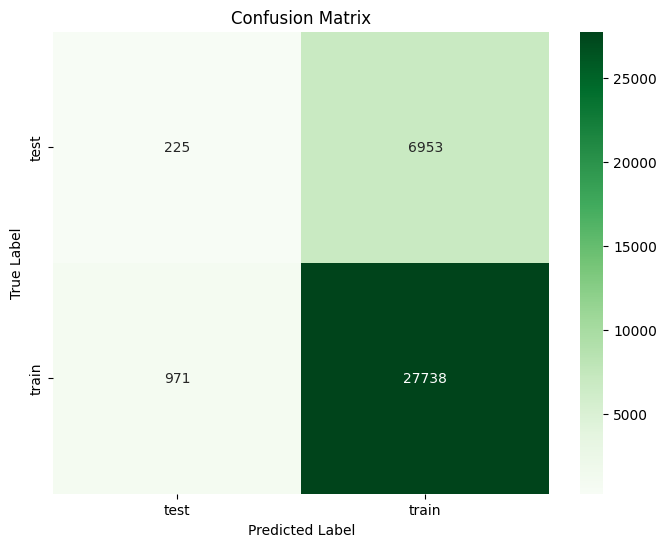

In [30]:
# Predictions on validation set
Y_pred = model.predict(val_gen)
Y_pred_classes = np.argmax(Y_pred, axis=1)   # Predicted class index
Y_true = val_gen.classes                     # True class index
class_labels = list(val_gen.class_indices.keys())  # Class names

# Confusion Matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Greens",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# **classification report**

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
print("\nClassification Report:\n")
print(classification_report(Y_true, Y_pred_classes, target_names=class_labels))


Classification Report:

              precision    recall  f1-score   support

        test       0.19      0.03      0.05      7178
       train       0.80      0.97      0.88     28709

    accuracy                           0.78     35887
   macro avg       0.49      0.50      0.46     35887
weighted avg       0.68      0.78      0.71     35887



# **final training accuracy and final validation accuracy**

In [33]:
history.history['accuracy'][-1]   # training accuracy
history.history['val_accuracy'][-1]  # validation accuracy

0.7804775834083557